In [1]:
# How to use our code for the Applied Data Science coursework
# 1. Import our package(s) and other useful tools
import pandas as pd
from applied_data_science.sentiment_pipeline import SentimentPipeline
from applied_data_science.time_series import get_time_series, get_change_points
from applied_data_science.data_access import get_general_covid_tweets as get_tweets
from applied_data_science.geo_visualisation import clean_locations, plotGlobalSentiments

import matplotlib.pyplot as plt
from datetime import date

In [16]:
# 2. Get some tweets and pickle them
original_df = get_tweets(start_date= date(2020, 1, 20), end_date=date(2021, 3, 28))
original_df.to_pickle("data.pkl")

Downloading: 100%|██████████| 2873113/2873113 [02:55<00:00, 16363.33rows/s]


In [2]:
# Load tweets back in
df = pd.read_pickle("data.pkl") # read from pickle
df.columns = ['id', 'location', 'text', 'date'] # set headers
df['date'] = pd.to_datetime(df['date']) # parse dates
df.head(10)

,id,location,text,date
0,1264343007727251457,"Los Angeles, CA",Amanda Kloots shares positive update on husban...,2020-05-23 23:50:38+00:00
1,1316151059530895360,Global,#Minnesota connects two dozen #coronavirus cas...,2020-10-13 22:57:20+00:00
2,1368905601133273089,World,Bavarian Nordic reports encouraging COVID-19 v...,2021-03-08 12:45:03+00:00
3,1269032122309849089,None,It is hard to believe what a wild and crazy ye...,2020-06-05 22:23:30+00:00
4,1272226082335457281,England,Coronavirus: Who should wear a face mask or fa...,2020-06-14 17:55:09+00:00
5,1230707321774362624,Switzerland,[🔴 NEWS] Could the coronavirus outbreak speed ...,2020-02-21 04:14:25+00:00
6,1237410214346928129,"Colorado, USA",#Truth\nTrump Blames Oil War and Coronavirus ‘...,2020-03-10 16:09:19+00:00
7,1354342525599948800,London - UK,Fixing health sector important than buying COV...,2021-01-27 08:16:35+00:00
8,1268909258420224001,Atlanta Georgia,Georgia Early Education Alliance for Ready Stu...,2020-06-05 14:15:17+00:00
9,1278458456937246721,None,Google Postpones US Office Reopening to Septem...,2020-07-01 22:40:23+00:00


In [3]:
# 3. Process your tweets in the sentiment pipelien
# set workers <= CPU cores, set chunksize based on dataset size (my data has 1.6 million tweets)
# threshold reccommended by VADER docs, change default labels if you want
# configure cleaning techniques (making text lower case, removing URLs, removing usernames, remove the # of a hashtag but keeping the text)
pipe = SentimentPipeline(workers=10, chunksize=100000, make_lower=False, remove_url=True, remove_user=True, remove_hash=False, threshold=0.05, pos_label=1, neu_label=0, neg_label=-1) 
df = pipe(df)
df.head(10) # note it is now indexed by time


CLEANING
100%|██████████| 2873113/2873113 [00:04<00:00, 687099.40it/s]

ANALYSING
100%|██████████| 2873113/2873113 [00:35<00:00, 81927.78it/s] 

CLASSIFYING
100%|██████████| 2873113/2873113 [00:01<00:00, 2651924.74it/s]

DONE


,id,location,text,date,clean_texts,sent_scores,sents
0,1264343007727251457,"Los Angeles, CA",Amanda Kloots shares positive update on husban...,2020-05-23 23:50:38+00:00,Amanda Kloots shares positive update on husban...,0.4939,1
1,1316151059530895360,Global,#Minnesota connects two dozen #coronavirus cas...,2020-10-13 22:57:20+00:00,#Minnesota connects two dozen #coronavirus cas...,0.0000,0
2,1368905601133273089,World,Bavarian Nordic reports encouraging COVID-19 v...,2021-03-08 12:45:03+00:00,Bavarian Nordic reports encouraging COVID-19 v...,0.5267,1
3,1269032122309849089,None,It is hard to believe what a wild and crazy ye...,2020-06-05 22:23:30+00:00,It is hard to believe what a wild and crazy ye...,-0.4215,-1
4,1272226082335457281,England,Coronavirus: Who should wear a face mask or fa...,2020-06-14 17:55:09+00:00,Coronavirus: Who should wear a face mask or fa...,0.0000,0
5,1230707321774362624,Switzerland,[🔴 NEWS] Could the coronavirus outbreak speed ...,2020-02-21 04:14:25+00:00,[🔴 NEWS] Could the coronavirus outbreak speed ...,0.0000,0
6,1237410214346928129,"Colorado, USA",#Truth\nTrump Blames Oil War and Coronavirus ‘...,2020-03-10 16:09:19+00:00,#Truth\nTrump Blames Oil War and Coronavirus ‘...,-0.6486,-1
7,1354342525599948800,London - UK,Fixing health sector important than buying COV...,2021-01-27 08:16:35+00:00,Fixing health sector important than buying COV...,0.2023,1
8,1268909258420224001,Atlanta Georgia,Georgia Early Education Alliance for Ready Stu...,2020-06-05 14:15:17+00:00,Georgia Early Education Alliance for Ready Stu...,0.6597,1
9,1278458456937246721,None,Google Postpones US Office Reopening to Septem...,2020-07-01 22:40:23+00:00,Google Postpones US Office Reopening to Septem...,-0.2732,-1


<AxesSubplot:ylabel='Frequency'>

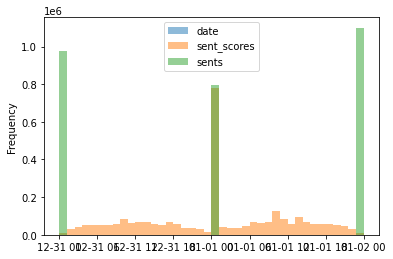

In [4]:
# Optional: visualise sentiment distribution
df.plot.hist(bins=40, alpha=0.5)

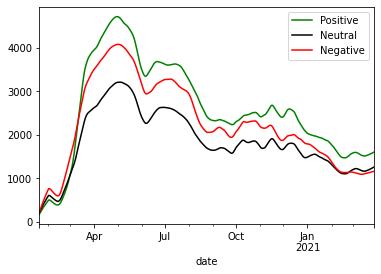

In [4]:
# 4. Generate time series data of tweet sentiment
# control seasonal/trend/residual decomposition (True = keep, False = remove)
# control normalisation (i.e. % of total )
# period: an odd number to represent the seasonality period (e.g. 7:weekly, 13:fortnightly, etc...)
pos, neu, neg = get_time_series(df, seasonal=False, trend=True, resid=False, period=13, norm=False)

def plot_time_series(pos, neu, neg):
    ax = plt.gca()
    pos.plot.line(color={'count':'green'}, ax=ax)
    neu.plot.line(color={'count':'k'}, ax=ax)
    neg.plot.line(color={'count':'red'}, ax=ax)
    ax.legend(["Positive", "Neutral", "Negative"])
    plt.show()

plot_time_series(pos, neu, neg)

In [4]:
# Determine change points
get_change_points(pos, neu, neg, plot=True)

NameError: name 'pos' is not defined

In [4]:
# Process and clean locations
df = clean_locations(df, workers=7, chunksize=100000)
df.head(20)


PRE-PROCESSING

100%|██████████| 2162431/2162431 [00:01<00:00, 1970618.75it/s]

CLEANING

100%|██████████| 2162431/2162431 [00:46<00:00, 46528.01it/s]


,id,location,text,date,clean_texts,sent_scores,sents,clean_location
0,1264343007727251457,"Los Angeles, CA",Amanda Kloots shares positive update on husban...,2020-05-23 23:50:38+00:00,Amanda Kloots shares positive update on husban...,0.4939,1,"[United States, USA, California, CA]"
1,1316151059530895360,Global,#Minnesota connects two dozen #coronavirus cas...,2020-10-13 22:57:20+00:00,#Minnesota connects two dozen #coronavirus cas...,0.0000,0,None
2,1368905601133273089,World,Bavarian Nordic reports encouraging COVID-19 v...,2021-03-08 12:45:03+00:00,Bavarian Nordic reports encouraging COVID-19 v...,0.5267,1,None
3,1272226082335457281,England,Coronavirus: Who should wear a face mask or fa...,2020-06-14 17:55:09+00:00,Coronavirus: Who should wear a face mask or fa...,0.0000,0,GBR
4,1230707321774362624,Switzerland,[🔴 NEWS] Could the coronavirus outbreak speed ...,2020-02-21 04:14:25+00:00,[🔴 NEWS] Could the coronavirus outbreak speed ...,0.0000,0,CHE
5,1237410214346928129,"Colorado, USA",#Truth\nTrump Blames Oil War and Coronavirus ‘...,2020-03-10 16:09:19+00:00,#Truth\nTrump Blames Oil War and Coronavirus ‘...,-0.6486,-1,"[United States, USA, Colorado, CO]"
6,1354342525599948800,London - UK,Fixing health sector important than buying COV...,2021-01-27 08:16:35+00:00,Fixing health sector important than buying COV...,0.2023,1,GBR
7,1268909258420224001,Atlanta Georgia,Georgia Early Education Alliance for Ready Stu...,2020-06-05 14:15:17+00:00,Georgia Early Education Alliance for Ready Stu...,0.6597,1,"[United States, USA, Georgia, GA]"
8,1262496704437329933,"Melbourne, Victoria",#abcnews 'That's not fair': Plight of Australi...,2020-05-18 21:34:05+00:00,#abcnews 'That's not fair': Plight of Australi...,-0.2411,-1,"[United States, USA, Florida, FL]"
9,1253426730724802562,"Ontario, Canada",@fordnation are you aware that seniors especia...,2020-04-23 20:53:14+00:00,are you aware that seniors especially women ...,0.2187,1,"[United States, USA, California, CA]"


In [5]:
fig = plotGlobalSentiments(df)
fig.ishow()

ValueError: cannot set a row with mismatched columns